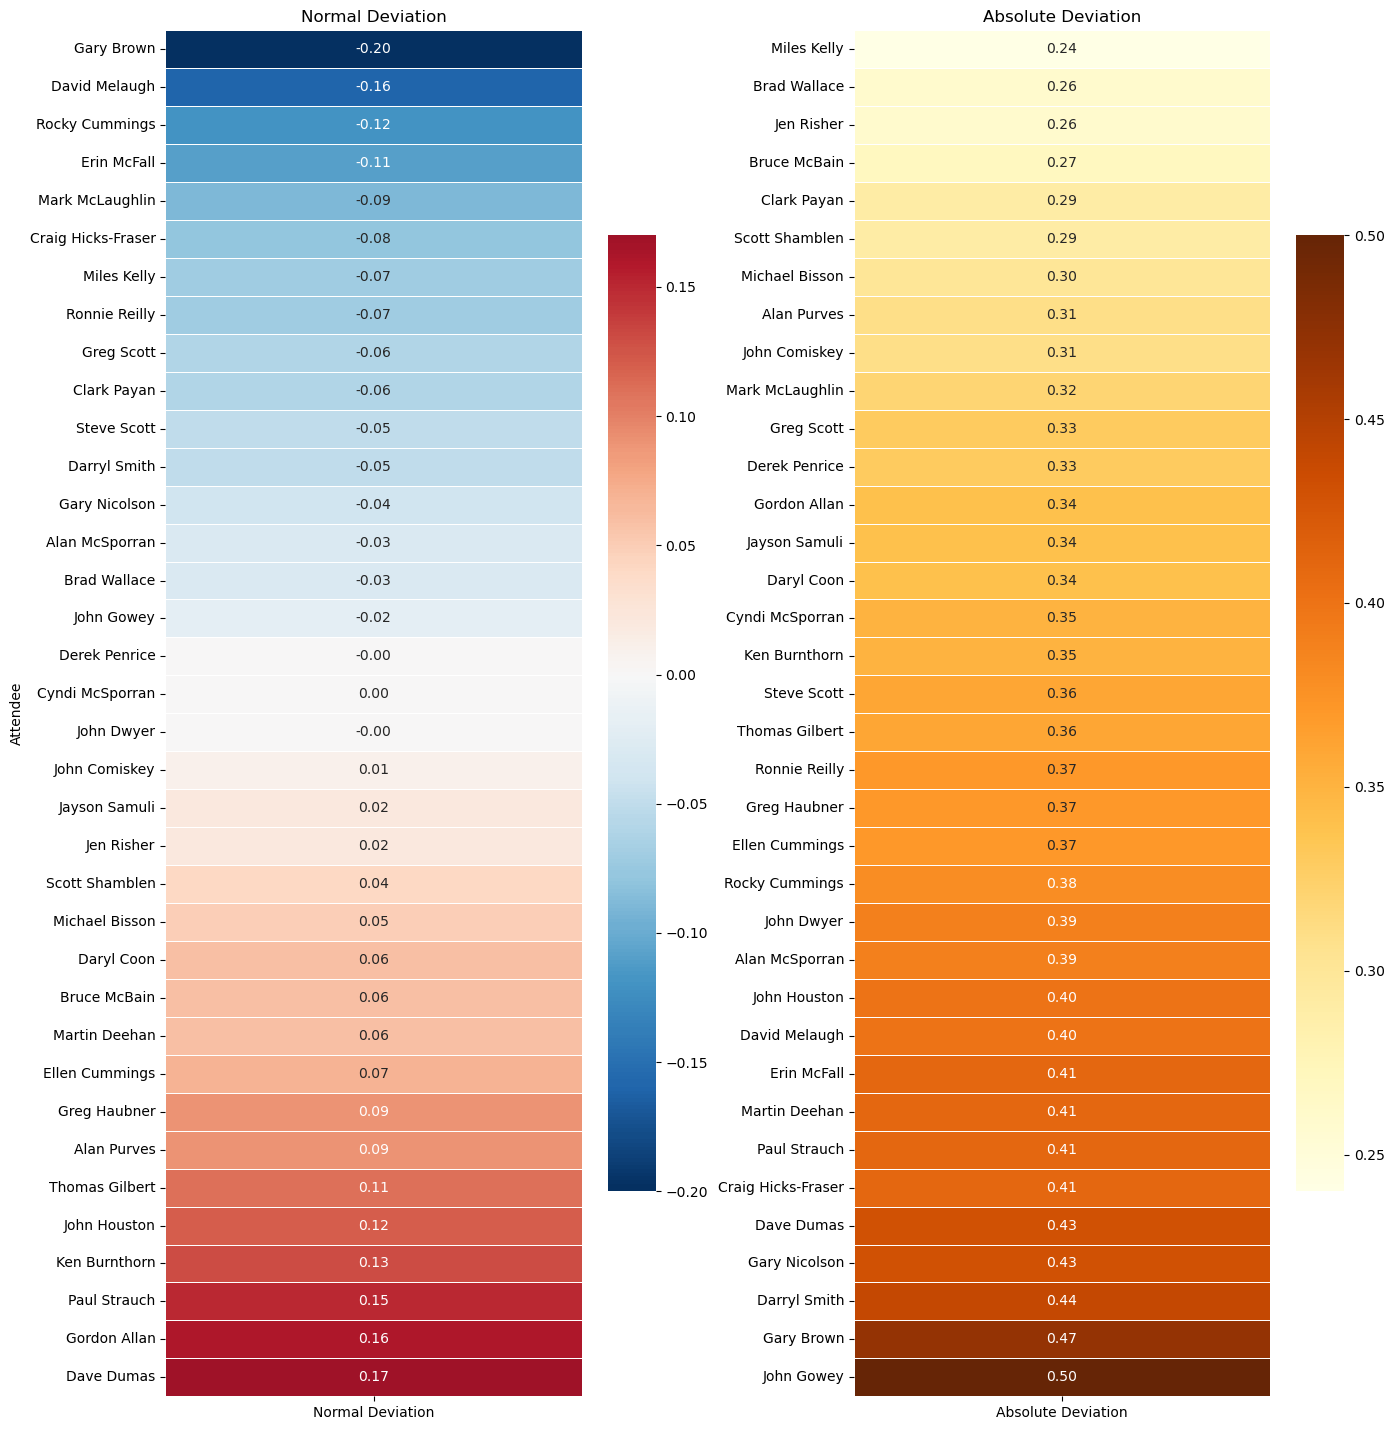

In [1]:
# This analyzes which tasters are 'hard' or 'easy' graders, 
# differing negatively or positively from the group average rating for each whisky.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import Data_Loading

df = Data_Loading.load_whisky_data(
    remove_guests=True,        # Remove guest scores
    remove_USwhiskies=False,   # Keep US whiskies in the dataset
    remove_thresh=0,           # No low score removal
    pointscale=False,          # No score rescaling
    fill_missing_age=True,     # Set a placeholder for missing whisky ages and adds a field noting this
    min_whiskies_per_region=0  # Does not remove any whiskies
)

attendee_score_filter = 100  # Minimum number of ratings required to be included

# Calculate the average score for each Whisky_ID
whisky_avg_scores = df.groupby('Whisky_ID')['Whisky_Score'].mean().reset_index()
whisky_avg_scores.rename(columns={'Whisky_Score': 'Average_Whisky_Score'}, inplace=True)

# Merge the average scores back into the original dataset
merged_data = pd.merge(df, whisky_avg_scores, on='Whisky_ID', how='left')

# Calculate the difference between each attendee's score and the average score
merged_data['Score_Deviation'] = merged_data['Whisky_Score'] - merged_data['Average_Whisky_Score']  # Normal version
merged_data['Abs_Score_Deviation'] = abs(merged_data['Score_Deviation'])  # Absolute value version

# Calculate each attendee's overall average deviation (normal and absolute)
attendee_deviations = merged_data.groupby('Attendee')['Score_Deviation'].mean().round(2)
attendee_abs_deviations = merged_data.groupby('Attendee')['Abs_Score_Deviation'].mean().round(2)

# Count the number of scores for each attendee and filter to those with more than attendee_score_filter scores
attendee_score_counts = df['Attendee'].value_counts()
valid_attendees = attendee_score_counts[attendee_score_counts > attendee_score_filter].index

# Filter deviations based on valid attendees
filtered_attendee_deviations = attendee_deviations[attendee_deviations.index.isin(valid_attendees)]
filtered_attendee_abs_deviations = attendee_abs_deviations[attendee_abs_deviations.index.isin(valid_attendees)]

# Combine both normal and absolute deviations into a single DataFrame
comparison_df = pd.DataFrame({
    'Normal Deviation': filtered_attendee_deviations,
    'Absolute Deviation': filtered_attendee_abs_deviations
})

# Sort each column independently
normal_sorted = comparison_df.sort_values(by='Normal Deviation', ascending=True)[['Normal Deviation']]
absolute_sorted = comparison_df.sort_values(by='Absolute Deviation', ascending=True)[['Absolute Deviation']]

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, len(comparison_df) * 0.4)) #adjust figure size as needed

# Normal Deviation Heatmap
sns.heatmap(normal_sorted, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=.5, cbar_kws={'shrink': 0.7}, ax=axes[0])
axes[0].set_title('Normal Deviation')
axes[0].set_ylabel('Attendee')

# Absolute Deviation Heatmap
sns.heatmap(absolute_sorted, annot=True, cmap='YlOrBr', fmt='.2f', linewidths=.5, cbar_kws={'shrink': 0.7}, ax=axes[1])
axes[1].set_title('Absolute Deviation')
axes[1].set_ylabel('')  # Remove duplicate y-label

plt.tight_layout() #prevents overlapping of titles
plt.show()

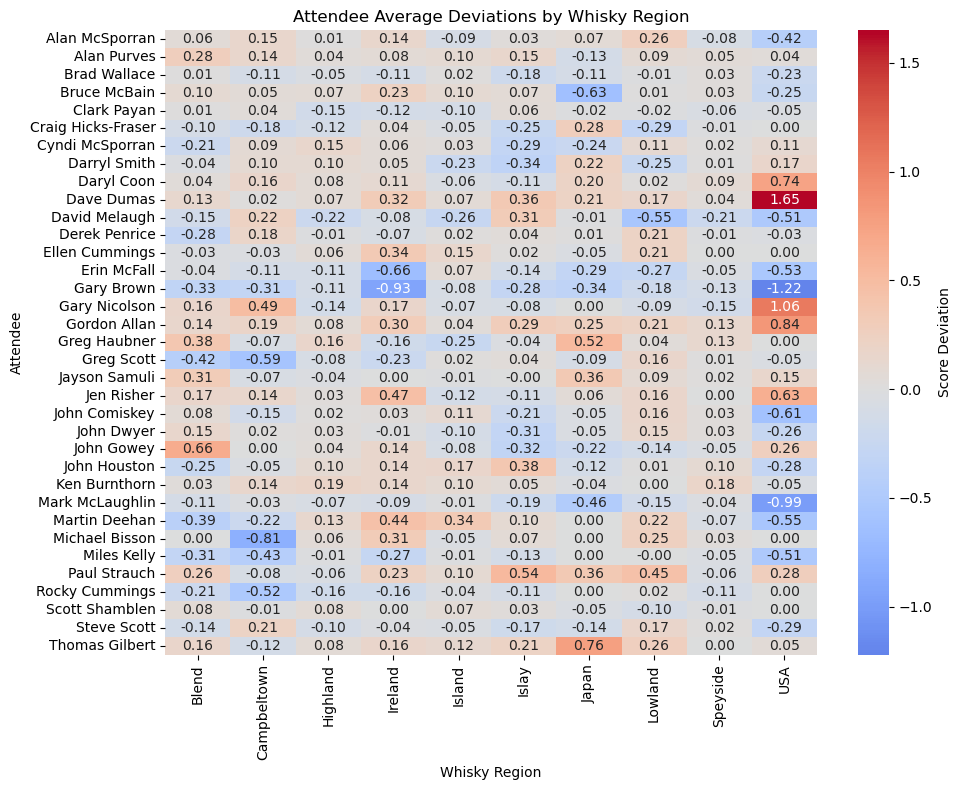

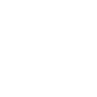

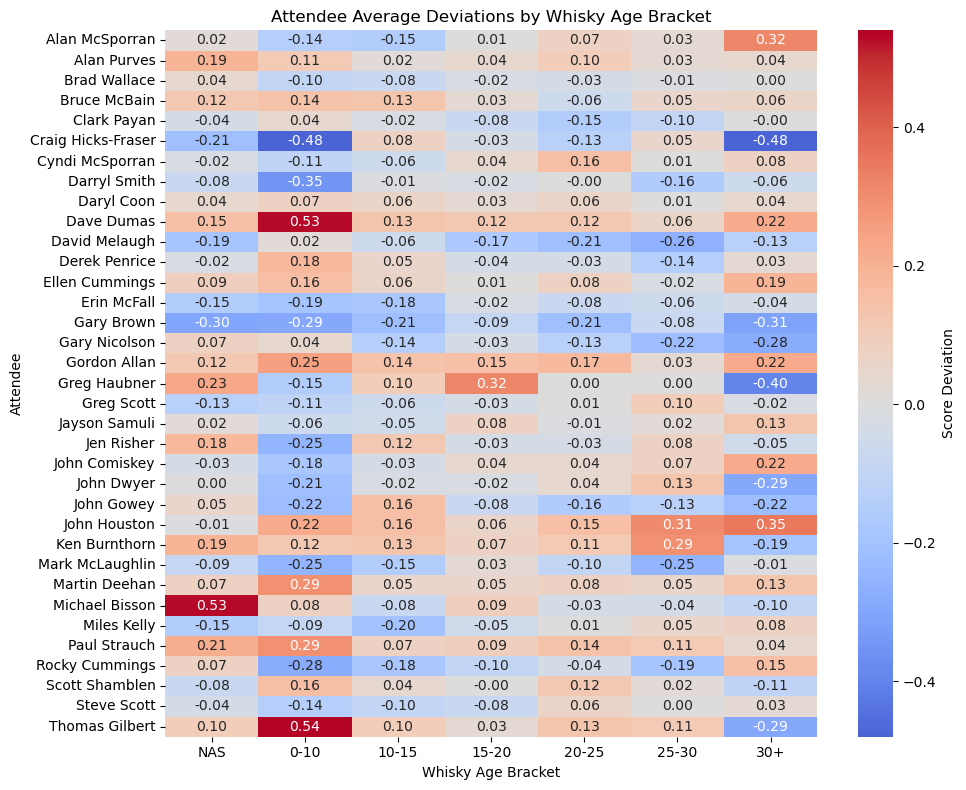

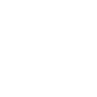

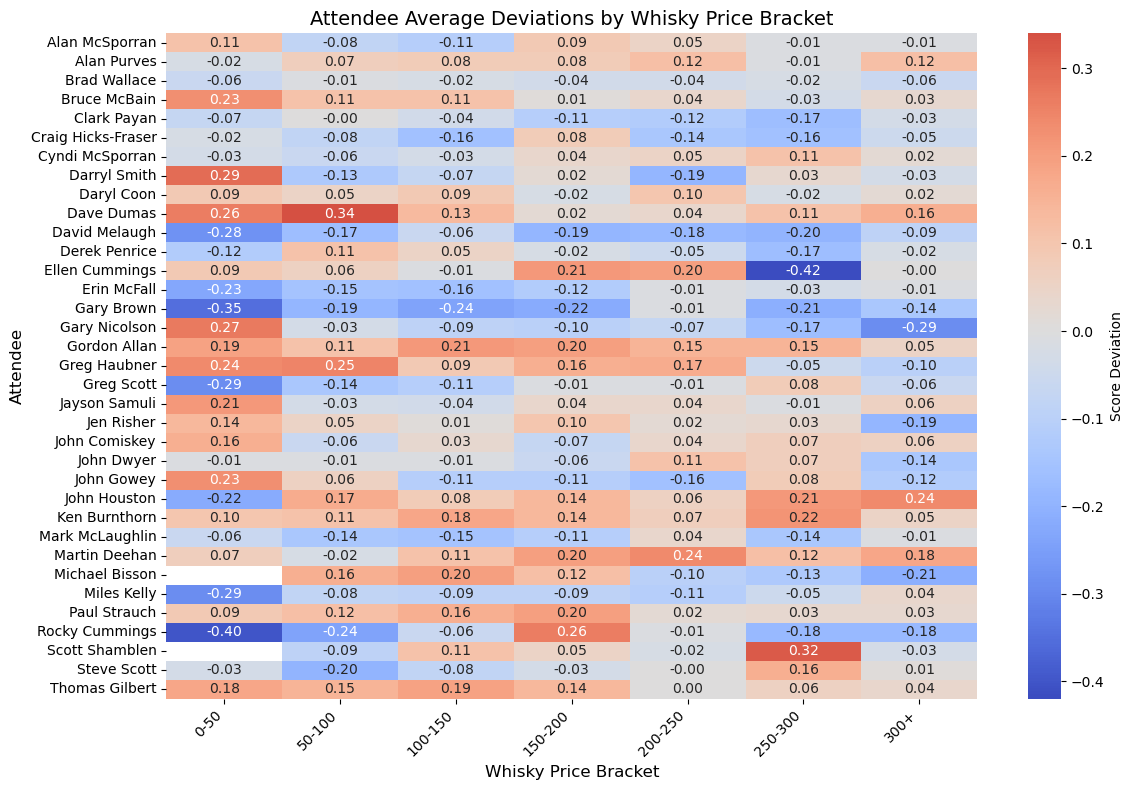

In [3]:
# This analyzes which tasters are 'hard' or 'easy' graders, 
# differing negatively or positively from the group average rating for each whisky, but with added focus
# on region, price, and age, to test whether an attendee's deviation from the average can be explained
# by preferences tied to those variables.  Focus for this is normal deviation, not absolute.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import Data_Loading

# Reload the data, but drop regions with fewer than 10 whiskies, to make output more legible

df = Data_Loading.load_whisky_data(
    remove_guests=True,        # Remove guest scores
    remove_USwhiskies=False,   # Keep US whiskies in the dataset
    remove_thresh=0,           # No low score removal
    pointscale=False,          # No score rescaling
    fill_missing_age=True,     # Set a placeholder for missing whisky ages and adds a field noting this
    min_whiskies_per_region=10 # Remove whiskies if there are fewer than 10 from the region
)

attendee_score_filter = 100

# Filter out attendees with fewer than attendee_score_filter scores
attendee_score_counts = df['Attendee'].value_counts()
valid_attendees = attendee_score_counts[attendee_score_counts >= attendee_score_filter].index
filtered_df = df[df['Attendee'].isin(valid_attendees)].copy()

# Calculate average scores and individual deviations from average
whisky_avg_scores = filtered_df.groupby('Whisky_ID')['Whisky_Score'].mean().reset_index()
whisky_avg_scores.rename(columns={'Whisky_Score': 'Average_Whisky_Score'}, inplace=True)
merged_data = pd.merge(filtered_df, whisky_avg_scores, on='Whisky_ID', how='left')
merged_data['Score_Deviation'] = merged_data['Whisky_Score'] - merged_data['Average_Whisky_Score']

# Set up age deviations
age_bins = [-2, -0.5, 10, 15, 20, 25, 30, float('inf')]
age_labels = ['NAS', '0-10', '10-15', '15-20', '20-25', '25-30', '30+']
merged_data['Age_Bracket'] = pd.cut(merged_data['Whisky_Age_Corrected'], bins=age_bins, labels=age_labels, include_lowest=True)

# Set up price deviations
price_bins = [0, 50, 100, 150, 200, 250, 300, np.inf]
price_labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300+']
merged_data['Price_Bracket'] = pd.cut(merged_data['Whisky_Price'], bins=price_bins, labels=price_labels, right=False)

# Compute average deviation per attendee per price bracket
price_deviation_matrix = merged_data.groupby(['Attendee', 'Price_Bracket'], observed=False)['Score_Deviation'].mean().unstack(fill_value=0)

# Plot heatmap for regional deviations
region_deviation_matrix = merged_data.groupby(['Attendee', 'Whisky_Region'])['Score_Deviation'].mean().unstack(fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(region_deviation_matrix.round(2), annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Score Deviation'}, fmt='.2f')
plt.title('Attendee Average Deviations by Whisky Region')
plt.xlabel('Whisky Region')
plt.ylabel('Attendee')
plt.tight_layout()
plt.show()

# Add spacing between plots
plt.figure(figsize=(1, 1))  
plt.axis('off')  
plt.show()

# Plot heatmap for age deviations
age_deviation_matrix = merged_data.groupby(['Attendee', 'Age_Bracket'], observed=False)['Score_Deviation'].mean().unstack(fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(age_deviation_matrix.round(2), annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Score Deviation'}, fmt='.2f')
plt.title('Attendee Average Deviations by Whisky Age Bracket')
plt.xlabel('Whisky Age Bracket')
plt.ylabel('Attendee')
plt.tight_layout()
plt.show()

# Add spacing between plots
plt.figure(figsize=(1, 1)) 
plt.axis('off')
plt.show()

# Plot heatmap for price deviations
plt.figure(figsize=(12, 8))
sns.heatmap(price_deviation_matrix.round(2), annot=True, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={'label': 'Score Deviation'})
plt.title('Attendee Average Deviations by Whisky Price Bracket', fontsize=14)
plt.xlabel('Whisky Price Bracket', fontsize=12)
plt.ylabel('Attendee', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()